In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
transform=transforms.Compose([transforms.Resize((160,160)),transforms.ToTensor()])
#step 1 Loading the data ad preprocessing
local_address=r'/home/uzair/Desktop/dataset/dataset/'
train_data=torchvision.datasets.ImageFolder(root=((local_address) + 'train/') ,
                                            transform=transforms.Compose([transforms.Resize((160,160)),transforms.ToTensor()]))
test_data=torchvision.datasets.ImageFolder(root=((local_address)+'valid/'),
                                           transform=transforms.Compose([transforms.Resize((160,160)),transforms.ToTensor()]))
train_loader=torch.utils.data.DataLoader(train_data,batch_size=8,
                                         shuffle=True,
                                         num_workers=4)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=2,
                                        shuffle=True,
                                        num_workers=4)
complete_data_dictionary={'train': train_loader , 'valid': test_loader}
print(complete_data_dictionary)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fa261539cf8>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7fa261539f28>}


In [3]:
print(len(train_loader))
batch=next(iter(test_data))
print(len(train_data))
print(len(test_data))

276
2206
551


torch.Size([8, 3, 160, 160])
8


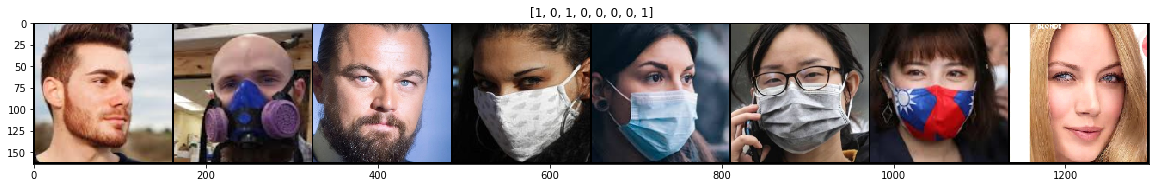

In [4]:
#step 2 Visualizing the data
def view_data(loaded_data):
    batch=next(iter(loaded_data))
    images,labels=batch
    print(images.shape)
    print(images.shape[0])
    my_grid=torchvision.utils.make_grid(images,nrow=images.shape[0])
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(my_grid,(1,2,0)))
    plt.title([x.item() for x in labels])
view_data(train_loader)

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")

In [5]:
#step 3 Making a training loop function which accepts the following parameters
# learning_rate,scheluder,model,test_data,train_data
#if input is training data , we need both forward and backward pass.
#If data is for validation, we need only forward pass

def my_train_model(model,data,optimizer,given_loss,scheduler,total_epochs=40):
    #making variables for plotting of graphs at later visualization stage
    train_loss , train_acc, val_loss, val_accuracy = [],[],[],[]
    #first epochs , then another loop in each epoch to cover training data
    #in each epoch,first train the model , and then run the validation data to test accuracy
    #ptimizer=optimize(model.parameters(),lr=learning_rate)
    my_sizes={ 'train': len(train_data), 'valid' : len(test_data)}
    #first loop for the epochs
    for i in range (total_epochs):
        print('EPOCH NO:' + str(i) )
        
        
            # decrease the learning rate after every given no of epochs
        
        #now second loop for complete loop over a training/validation data
        #each epoch will run two times , one for the training , 2nd for the validation
        
        for current_run in ['train' , 'valid']:
            current_epoch_loss=0.0
            total_correct=0.0
            
            if current_run=='train':
                model.train()       #run the model in the training mode 
                scheduler.step()
            else: 
                model.eval()   #run model in validation mode
            
            for batch in data[current_run]:
                
                
                #now performing the forward steps 
                input_data,labels=batch
                #put data into GPU processing if available
                input_data=input_data.to(device)
                labels=labels.to(device)
                
                #print(current_run)
                
                #now for validation , only forward pass is required
                with torch.set_grad_enabled(current_run=='train'):
                    #forward pass
                    my_prediction=model(input_data)
                    #find loss
                    loss=given_loss(my_prediction,labels)
                    #clear previous gradients
                    #Run backward for only training time
                    if current_run=='train':
                        optimizer.zero_grad()
                        #update gradients
                        loss.backward()
                        optimizer.step()
                    
                    
                    
                    current_epoch_loss +=loss.item()*input_data.size(0)
                    total_correct+=my_prediction.argmax(dim=1).eq(labels).sum().item()
                    
                    
                    
                
            #now printing the loss after 1 epoch
                
            print(str(current_run) + '  loss = '  + str(current_epoch_loss))
            print(str(current_run) + ' Accuracy= ' +  str(total_correct/my_sizes[current_run]))
            if current_run=='train':
                        train_acc.append(total_correct/my_sizes[current_run])
                        train_loss.append(current_epoch_loss/my_sizes[current_run])
            else:
                val_accuracy.append(total_correct/my_sizes[current_run])
                val_loss.append(current_epoch_loss/my_sizes[current_run])
    return model        

In [6]:
#now making of the network
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
    self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.fc1=nn.Linear(in_features=12*37*37,out_features=120)
    self.fc2=nn.Linear(in_features=120,out_features=60)
    self.out=nn.Linear(in_features=60,out_features=2)

  def forward(self,t):
    #input layer
    t=t
    #conv1 layer
    t=self.conv1(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=(2,2),stride=2)
    #2nd conv2d layer
    t=self.conv2(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=(2,2),stride=2)
    #now linear layer implementation
    #first flatten the conv layer output 
    t=t.reshape(-1,12*37*37)
    t=self.fc1(t)
    t=F.relu(t)
    #next linear
    t=self.fc2(t)
    t=F.relu(t)
    #final layer
    t=self.out(t)
#     t=torch.sigmoid(t)
    
    return t


In [ ]:
#Now making arguments for above ftn
no_of_classes=250

my_model=Network()
learning_rate1=0.001
my_loss=nn.CrossEntropyLoss()
my_optimizer=torch.optim.Adam(my_model.parameters(),lr=learning_rate1)
dynamic_learning_rate=torch.optim.lr_scheduler.StepLR(my_optimizer,step_size=7,gamma=0.1)
trained_model=my_train_model(model=my_model.cuda(),data=complete_data_dictionary,
               optimizer=my_optimizer,
                    given_loss=my_loss,
               scheduler=dynamic_learning_rate)


In [ ]:
torch.save(trained_model ,r'/home/uzair/Desktop/dataset/mask_detector1')

In [7]:
trained_model=torch.load(r'/home/uzair/Desktop/dataset/mask_detector1')

In [8]:
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('/home/uzair/Desktop/c.jpg')


In [ ]:
test=transform(image)
test=test.unsqueeze(0)

In [ ]:
trained_model.eval()
my_prediction=F.softmax(trained_model(test.cuda()))
my_prediction.argmax(dim=1).item()
#remember 1 means NO MASK
#zero means MASK

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 28 16:54:47 2020

@author: mkhat
"""

import cv2
import numpy as np
import datetime
cap = cv2.VideoCapture(0)
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('/home/uzair/Desktop/my1my.mp4', fourcc, 20.0, (480,640))
from mtcnn.mtcnn import MTCNN
detector=MTCNN()

access_text='Welcome ,Access Given'
deny_text='Please Wear a Mask , Access Denied'

while True:
    ret, frame = cap.read()
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result=detector.detect_faces(frame)
    font_type=cv2.FONT_HERSHEY_PLAIN
    if (result!=[]):
        #then we it has detected a face 
        for person in result:
            #each person varaible will be a dtictionary conotaining the bounding boxes 
            #and other info
            box=person['box']
            #draw the bounding box on the input image frame
            cv2.rectangle(frame,(box[0],box[1]),((box[0]+box[2]),(box[1]+box[3])),(0,155,255),2)
            #some texts to be written on live feed
            cv2.putText(frame,'LIVE MASK DETECTOR',(10,20),font_type,1.5,(0,255,255),1,cv2.LINE_AA)
            cv2.putText(frame,str(datetime.datetime.now()),(10,40),font_type,1.5,(0,255,0),1,cv2.LINE_AA)
            
            #also we need to cropout the face , for input to the pytorch model
            extracted_face=frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
#             print(frame.shape)
            
            
            test_img=Image.fromarray(extracted_face)
            test_img=transform(test_img)
            test_img=test_img.unsqueeze(0)
            my_prediction=F.softmax(trained_model(test_img.cuda()))
            ans=my_prediction.argmax(dim=1).item()
            
            if (ans==0):
                cv2.putText(frame,access_text,(100,100),font_type,2,(0,255,0),2,cv2.LINE_AA)
            else:
                cv2.putText(frame,deny_text,(20,100),font_type,2,(255,0,0),2,cv2.LINE_AA)
            
#     frame=cv2.resize(frame,(600,800))
 #   out.write(frame)
#    cv2.imwrite('testtest.tiff',frame)
    cv2.imshow('frame', frame)
#    cv2.imshow('gray', gray)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
# out.release()
cv2.destroyAllWindows()



(480, 640, 3)


/home/uzair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 